# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project plan

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

Import required libraries.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Load data.

In [2]:
try:
    df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

Inspect data.

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


No missing values.

In [5]:
df.index.is_monotonic

True

Data is already sorted correctly.

Resampling to 1 hour intervals.

In [6]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

The data plotted.

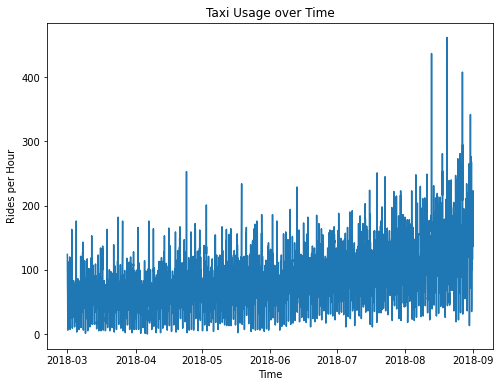

In [7]:
plt.figure(figsize=(8,6))
plt.title('Taxi Usage over Time')
plt.xlabel('Time')
plt.ylabel('Rides per Hour')
plt.plot(df)
plt.show()

It's very noisy. We can use sseasonal decomposition to reveal trends and periodical changes.

In [8]:
decomp = seasonal_decompose(df)

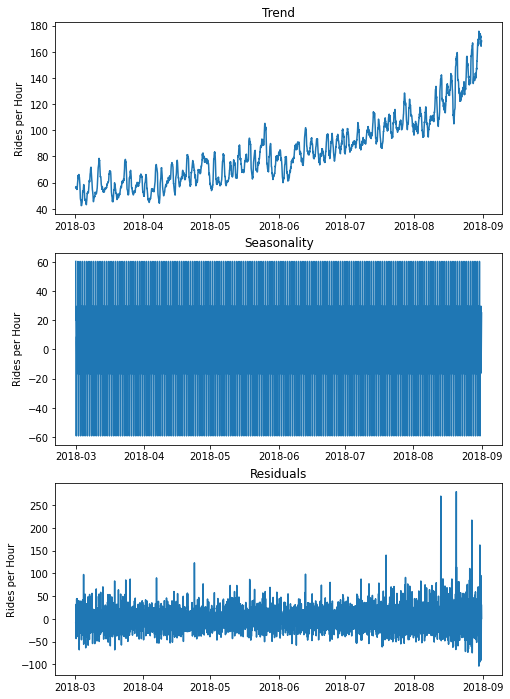

In [25]:
plt.figure(figsize=(8,12))
plt.subplot(311)
plt.title('Trend')
plt.ylabel('Rides per Hour')
plt.plot(decomp.trend, label='trend')
plt.subplot(312)
plt.title('Seasonality')
plt.ylabel('Rides per Hour')
plt.plot(decomp.seasonal, label='seasonal')
plt.subplot(313)
plt.title('Residuals')
plt.ylabel('Rides per Hour')
plt.plot(decomp.resid, label='residual')
plt.show()

We see a steady rise in demand over the 6 months of data collection. We cannot tell if it is a seasonal change or a real trend without multi-year data. Noise is mostly within +/- 50 rides per hour. The periodical change is hard to see, so we'll zoom in on a 72 hour time frame.

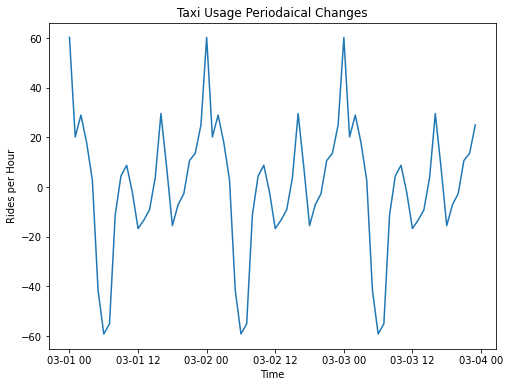

In [10]:
plt.figure(figsize=(8,6))
plt.title('Taxi Usage Periodaical Changes')
plt.xlabel('Time')
plt.ylabel('Rides per Hour')
plt.plot(decomp.seasonal[:72])
plt.show()

There's a 24 hour repeating pattern. The hour of the day can make up to 120 rides per hour difference.

## Training

Create features.

In [11]:
def make_features(df, max_lag, rolling_mean_size, inplace=False):
    ret = df.copy()
    
    ret['month'] = ret.index.month
    ret['day'] = ret.index.day
    ret['dayofweek'] = ret.index.dayofweek
    ret['hour'] = ret.index.hour

    for lag in range(1, max_lag + 1):
        ret['lag_{}'.format(lag)] = ret.iloc[:, 0].shift(lag)

    ret['rolling_mean'] = (
        ret.iloc[:, 0].shift().rolling(rolling_mean_size).mean()
    )
    
    ret = ret.dropna()
    
    if inplace:
        df = ret
    else:
        return ret

In [12]:
data = make_features(df, 10, 10)

Split data to training, validation and testing sets in 8-1-1 ratio.

In [13]:
x = data.drop('num_orders', axis=1)
y = data['num_orders']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, shuffle=False, test_size=0.2)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, shuffle=False, test_size=0.5)

Create, train and get validation score of a linear regression.

In [14]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_score = mean_squared_error(y_valid, lr.predict(x_valid), squared=False)
print(lr_score)

40.48809428266595


Create, train and get validation score of a default decision tree.

In [15]:
baseline_tree = DecisionTreeRegressor(random_state=123)
baseline_tree.fit(x_train, y_train)
baseline_tree_score = mean_squared_error(y_valid, baseline_tree.predict(x_valid), squared=False)
baseline_tree_depth = baseline_tree.get_depth()
print(baseline_tree_score)

40.79668631779389


Optimize hyperparameters.

In [16]:
best_tree_para = {'max_depth': baseline_tree_depth, 'min_samples_leaf': 1, 'score': baseline_tree_score}

for d in range (5, 15, 1):
    for msl in range(5, 15, 1):
        tree = DecisionTreeRegressor(max_depth=d, min_samples_leaf=msl, random_state=123)
        tree.fit(x_train, y_train)
        score = mean_squared_error(y_valid, tree.predict(x_valid), squared=False)

        if score < best_tree_para['score']:
            best_tree_para = {'max_depth': d, 'min_samples_leaf': msl, 'score': score}
            print(best_tree_para)

print('done.')

{'max_depth': 6, 'min_samples_leaf': 5, 'score': 37.35054499555917}
{'max_depth': 7, 'min_samples_leaf': 5, 'score': 35.02558919157829}
{'max_depth': 7, 'min_samples_leaf': 6, 'score': 35.022649773676314}
{'max_depth': 8, 'min_samples_leaf': 5, 'score': 34.62647637550386}
{'max_depth': 8, 'min_samples_leaf': 8, 'score': 34.13575247210615}
{'max_depth': 8, 'min_samples_leaf': 9, 'score': 34.11155061598633}
{'max_depth': 8, 'min_samples_leaf': 10, 'score': 34.00582185142167}
{'max_depth': 9, 'min_samples_leaf': 8, 'score': 33.594179361209676}
{'max_depth': 9, 'min_samples_leaf': 10, 'score': 33.588539261474565}
done.


Create the final decision tree model.

In [17]:
best_tree = DecisionTreeRegressor(max_depth=best_tree_para['max_depth'], 
                                  min_samples_leaf=best_tree_para['min_samples_leaf'], random_state=123)

Optimize the number of trees in a random forest, where each tree has the same hyperparameters as the above optimized decision tree.

In [18]:
best_forest_para = {'n_estimators': 0, 'score': 99999}

for n in range(200, 1001, 200):
    forest = RandomForestRegressor(n_estimators=n, max_depth=best_tree_para['max_depth'], 
                                   min_samples_leaf=best_tree_para['min_samples_leaf'], random_state=123)
    forest.fit(x_train, y_train)
    score = mean_squared_error(y_valid, forest.predict(x_valid), squared=False)
    print(n, score)
    if score < best_forest_para['score']:
        best_forest_para = {'n_estimators': n, 'score': score}

print('done.')

200 32.966348907348944
400 32.87821310087535
600 32.853486397136386
800 32.82606510290016
1000 32.86334864860287
done.


Create the final random forest model.

In [19]:
best_forest = RandomForestRegressor(n_estimators=best_forest_para['n_estimators'], 
                                    max_depth=best_tree_para['max_depth'], 
                                    min_samples_leaf=best_tree_para['min_samples_leaf'], random_state=123)

## Testing

Combine train and validation sets for final training.

In [20]:
x_train_final = pd.concat([x_train, x_valid])
y_train_final = pd.concat([y_train, y_valid])

Final training of selected models.

In [21]:
lr.fit(x_train_final, y_train_final)
lr_score = mean_squared_error(y_test, lr.predict(x_test), squared=False)

In [22]:
best_tree.fit(x_train_final, y_train_final)
best_tree_score = mean_squared_error(y_test, best_tree.predict(x_test), squared=False)

In [23]:
best_forest.fit(x_train_final, y_train_final)
best_forest_score = mean_squared_error(y_test, best_forest.predict(x_test), squared=False)

Results.

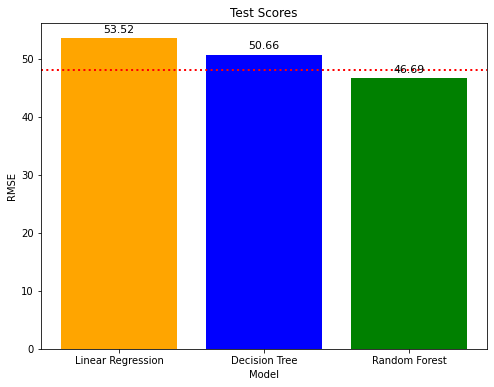

In [24]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
scores = [lr_score, best_tree_score, best_forest_score]
colors = ['orange', 'blue', 'green']

plt.figure(figsize=(8, 6))
plt.title('Test Scores')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.bar(models, scores, color=colors)
for model, score in zip(models, scores):
    plt.text(model, score+1, round(score, 2), ha='center', size=11)
plt.axhline(48, color='r', ls=':', lw=2)
plt.show()

The tuned random forest model scored lower than 48 and thus passed the test. Not much luck for the other two. The big difference between test scores (46.7-53.5) and validation scores (32.8-40.5) can be explained by how the data becomes more noisy at later times and an apparent acceleration in growth of demand.